# ECE6530 DSP Group 3 Project
### Group Members: Grant Brown, Thomas Warren, Rick Lyon

In [1]:
# Load the required libraries
import matplotlib.pyplot as plt
import numpy as np

from IPython import display
from scipy.io import loadmat, wavfile

from utils import stem_plot, upc_decode, decode_image, filter_2d

%config InlineBackend.figure_formats = ['svg']

Setup
---------

To generate this report and the associated plots:

1. Install Python 3.11.
2. Open a terminal window and navigate to the directory containing the project files. 
2. Create an virtual environment for the report/project. See [here](https://docs.python.org/3/library/venv.html) for more information.  
`> python -m venv .venv`
4. In the newly created environment, install the required packages from the requirements.txt file included with the project files.  
`(.venv) > pip install -r requirements.txt`
5. Open the report with Jupyter Notebooks.  
`(.venv) > jupyter notebook report.ipynb`
6. The notebook should open in the default browser. 

7. To generate the .html version of the report,  
`(.venv) > jupyter nbconvert --to html report.ipynb`

# Lab P-9: Sampling, Convolution, and FIR Filtering
------

# 3.1 - Deconvolution Experiment for 1-D Filters

Implement the following FIR filter
$$ w[n] = x[n] - 0.9x[n-1]$$
on the input signal x[n] defined via the MATLAB statement: 
```
xx = 256*(rem(0:100,50)<10);
```
In MATLAB you must define the vector of filter coefficients bb needed in `firfilt`.

## (a) 

Plot both the input and output waveforms x[n] and w[n] on the same figure, using subplot. Make the discrete-time signal plots with MATLAB’s stem function, but restrict the horizontal axis to the range $0 \leq n \leq 75$.  
Explain why the output appears the way it does by figuring out (mathematically) the effect of the filter coefficients in (3).

The output is the difference of the current sample n and the previous sample at n-1 with an scalar of 0.9 applied to the previous sample. The scalar causes the difference to be nonzero and 0.1 times the previous value. The edges of x[n] are visible due to the difference equation causing the value to be 0.9 times the previous value. The effect of the filter coefficients is essentially an edge detection or derivative filter.

Text(0.5, 0, 'Samples')

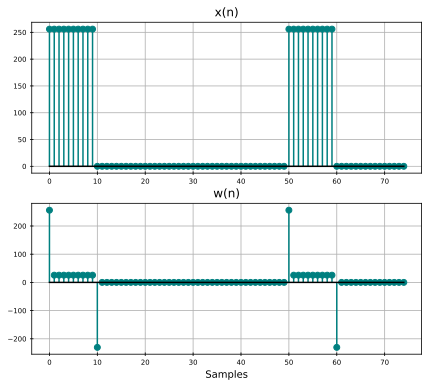

In [2]:
# create xn signal
n = np.arange(0, 101)
x_n = 256 * ((n % 50) < 10)

# apply difference FIR filter to create wn
w_n = np.convolve([1, -0.9], x_n)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6))
stem_plot(ax1, n[0:75], x_n[0:75])
stem_plot(ax2, n[0:75], w_n[0:75])

ax1.set_title("x(n)")
ax2.set_title("w(n)")
ax2.set_xlabel("Samples")

## (b) 

Note that w[n] and x[n] are not the same length. Determine the length of the filtered signal w[n], and explain how its length is related to the length of x[n] and the length of the FIR filter. (If you need a hint refer to Section 1.2.)

The FIR filter in this example has coefficients $bb = [1 0.9]$, so it is length 2. The output of the convolution can be determined by the length of the two sequences given as inputs to the convolution operation, which in this case would be:
$$
\mathrm{len}(w[n]) = \mathrm{len}(x[n]) + \mathrm{len}(bb) -1 = 101 + 2 - 1 = 102
$$

# 3.1.1 Restoration Filter
------

The following FIR filter:
$$ y[n] = \sum_{l=0}^{M} r^l w[n-l] $$
can be use to undo the effects of the FIR filter in the previous section. It performs restoration, but it only does this approximately. Use the following steps to show how well it works when r = 0.9 and M = 22.

## (a) 

Process the signal $w[n]$ from (3) with FILTER-2 to obtain the output signal $y[n]$.

## (b) 

Make stem plots of $w[n]$ and $y[n]$ using a time-index axis n that is the same for both signals. Put the stem plots in the same window for comparison—using a two-panel subplot.

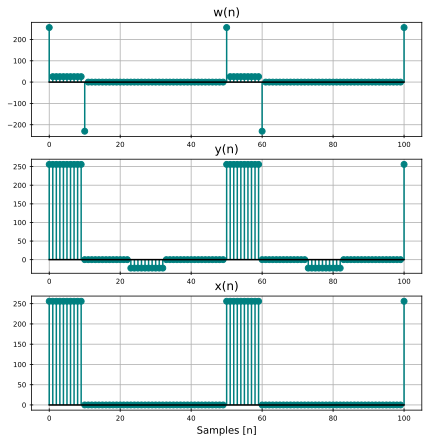

In [3]:
# build restoration filter cooeficients
M = 22
l = np.arange(0, M + 1, dtype=np.int8)
r = 0.9**l
y_n = np.convolve(r, w_n)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 7))
stem_plot(ax1, n, w_n[:-1])
stem_plot(ax2, n, y_n[: -M - 1])
stem_plot(ax3, n, x_n)

ax1.set_title("w(n)")
ax2.set_title("y(n)")
ax3.set_title("x(n)")
ax3.set_xlabel("Samples [n]");

# (c) 

Since the objective of the restoration filter is to produce a y[n] that is almost identical to x[n], make a plot of the error (difference) between x[n] and y[n] over the range $0 < n < 50$.

Text(0.5, 16.878125000000008, 'Samples [n]')

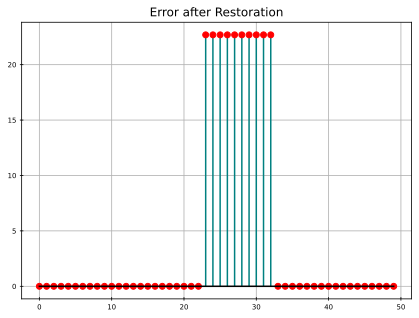

In [4]:
error = np.abs(y_n[:50] - x_n[:50])

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.stem(error, markerfmt="red")
ax.title.set_text("Error after Restoration")
ax3.set_xlabel("Samples [n]")

# 3.1.2 - Worst-Case Error
----
# (a) 
Evaluate the worst-case error by doing the following: use MATLAB’s max() function to find the maximum of the difference between y[n] and x[n] in the range $0 < n < 50$.

# (b) 
What does the error plot and worst case error tell you about the quality of the restoration of x[n]? How small do you think the worst case error has to be so that it cannot be seen on a plot?

In [5]:
max_error = np.max(error[0:50])
print(f"Maximum Error found is {max_error:.3f}")

Maximum Error found is 22.689


The error plot will show how effective the deconvolution/restoration operation is. The maximum error can be used as a threshold for a certain application to allow us to determine how high an order of a deconvolution filter we need. Increasing M, the filter order, has shown to create a better deconvolution operation. In order to no longer see the error in our plots, the value of error would need to be smaller than 0.1. Anything smaller than 0.1 would be hard to detect with the markers for the stem plot. 

# 3.1.3 - An Echo Filter
-------

The following FIR filter can be interpreted as an echo filter.
$$y_1[n] = x_1[n] + rx_1[n-P]$$

Explain why this is a valid interpretation by working out the following:

# (a) 
You have an audio signal sampled at $f_s = 8000 Hz$ and you would like to add a delayed version of the signal to simulate an echo. The time delay of the echo should be 0.2 seconds, and the strength of the echo should be 90% percent of the original. Determine the values of r and P in (4); make P an integer.

To solve this we must known how many samples we are offsetting by with the 0.2 seconds of delay. Since we are sampling at 8000 Hz which is 8000 samples/sec, then we are offsetting by: $8000 samples/sec * 0.2 sec = 1600 samples$. Therefore, P should be 1600. Since the signal should be at 90% of its value then r should be 0.9. Giving the echo filter equation:

$$y_1[n] = x_1[n] + 0.9 \ x_1[n-1600]$$

In [6]:
# playback original data before filtering
orig_data = loadmat("data/labdat.mat")["x2"].squeeze()
orig_wavfile = "data/outputs/labdat.wav"
fs = 8000  # sampling rate

wavfile.write(orig_wavfile, fs, orig_data)
display.Audio(orig_wavfile)

# (b) 

Describe the filter coefficients of this FIR filter, and determine its length.
A FIR filter is in the form:
$$y[n] = \sum_{k=0}^{M} = b_k x[n-k]$$

with $b_k$ being the coefficients of the filter. This means that k = 1600 here and therefore the coefficients range from k=0 to 1600. Therefore the length of the filter is 1601.
The coefficients are  
`bb = [1; zeros(1599); 0.9]`

In [7]:
td = 0.2  # time delay of echo in seconds
echo_amp = 0.9  # amplitude of echo

samp_delay = int(fs * td)  # total number of samples to delay the echo by
# create filter cooeficients
bk = np.zeros(samp_delay, dtype=float)
bk[0] = 1
bk[samp_delay - 1] = echo_amp

# apply filter to input data to create echo
echo_data = np.convolve(orig_data, bk)
echo_data_scaled = np.int16(echo_data / np.max(np.abs(echo_data)) * 32767)

# create wavfile and playback
echo_wavfile = "data/outputs/Echo_data.wav"
wavfile.write(echo_wavfile, fs, echo_data_scaled)

display.Audio(echo_wavfile)

# 3.2 Cascading Two Systems
----

More complicated systems are often made up from simple building blocks. In the system of Fig. 3 two FIR filters are connected “in cascade.” 

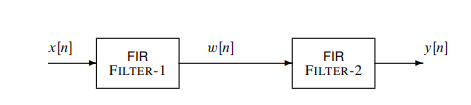

For this section, assume that the the filters in Fig. 3 are described by the two equations:

$$w[n] = x[n] - qx[n-1]$$
$$y[n] = \sum_{l=0}^{M} r^l w[n-l]$$



# 3.2.1 Overall Impulse Response
-------

# (a) 

Implement the system in Fig. 3 using MATLAB to get the impulse response of the overall cascaded system for the case where q = 0.9, r = 0.9 and M = 22. Use two calls to `firfilt()`. Plot the impulse response of the overall cascaded system.

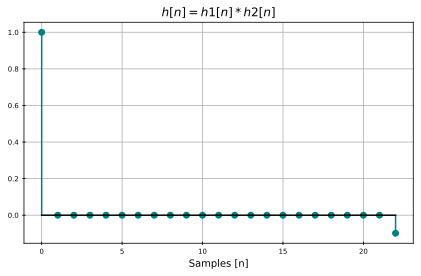

In [8]:
q = 0.9
r = 0.9
M = 22
h1_n = np.array([1, -q])

n = np.arange(M)
h2_n = r**n

hn = np.convolve(h2_n, h1_n)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
stem_plot(ax, np.arange(len(hn)), hn)
ax.set_title("$h[n] = h1[n] * h2[n]$")
ax.set_xlabel("Samples [n]");

# (b) 

Work out the impulse response h[n] of the cascaded system by hand to verify that your MATLAB result in part (a) is correct. (Hint: consult old Homework problems.)

To solve this we should note that convolution in time domain is multiplication in frequency domain,

$$W[z] = X[z](1-qz^{-1}) \longrightarrow H_1(z) = W[z] / X[z] = (1-qz^{-1})$$

$$Y[z] = W[z]R[z]$$ 

where,
$$Z^{-1}(R[z]) = r[n] = r^n(u[n] - u(n-22))$$

Taking the Z-transform of r[n] we get:
$$R[z] = \sum_{n=-\infty}^{\infty}(\dfrac{r}{z})^n u[n] - \sum_{n=-\infty}^{\infty}(\dfrac{r}{z})^n u[n-22]$$
$$R[z] = \sum_{n=0}^{\infty}(\dfrac{r}{z})^n - \sum_{n=22}^{\infty}(\dfrac{r}{z})^n$$
$$R[z] = \sum_{n=0}^{\infty}(\dfrac{r}{z})^n - r^{22} z^{-22} \sum_{n=0}^{\infty}(\dfrac{r}{z})^n$$
$$R[z] = \dfrac{1}{1-rz^{-1}} - \dfrac{r^{22} z^{-22}}{1-rz^{-1}}$$

The total system function of the cascaded system is:
$$H_{total}[z] = W[z] * R[z] = (1-qz^{-1})*(\dfrac{1}{1-rz^{-1}} - \dfrac{r^{22} z^{-22}}{1-rz^{-1}})$$
Since r=q in the instance we get:
$$H_{total}[z] = W[z] * R[z] = 1 + r^{22}z^{-22}$$
Taking the inverse Z-transform of this we get:
$$h_{total}[n] = \delta [n] + r^{22}\delta [n-22]$$
This is essentially a delta function with a negative scaled echo of the delta function. We see that M works as an attenuation factor here.

# (c) 

In a deconvolution application, the second system (FIR FILTER-2) tries to undo the convolution effect of the first. Perfect deconvolution would require that the cascade combination of the two systems be equivalent to the identity system: y[n] = x[n]. If the impulse responses of the two systems are $h_1[n]$ and $h_2[n]$, state the condition on $h_1[n]$ * $h_2[n]$ to achieve perfect deconvolution.

To implement perfect deconvolution we should note that convolution of x[n] with an impulse just gives x[n] at the output. Therefore $h_1[n]$ * $h_2[n]$ = $\delta [n]$

# 3.2.2 Distorting and Restoring Images
------

If we pick q to be a little less than 1.0, then the first system (FIR FILTER-1) will cause distortion when applied to the rows and columns of an image. The objective in this section is to show that we can use the second system (FIR FILTER-2) to undo this distortion (more or less). Since FIR FILTER-2 will try to undo the convolutional effect of the first, it acts as a deconvolution operator.

# (a) 

Load in the image echart.mat with the load command. It creates a matrix called echart.
# (b) 

Pick q = 0.9 in FILTER-1 and filter the image echart in both directions: apply FILTER-1 along the horizontal direction and then filter the resulting image along the vertical direction also with FILTER-1. Call the result ech90.
# (c) 

Deconvolve ech90 with FIR FILTER-2, choosing M = 22 and r = 0.9. Describe the visual appearance of the output, and explain its features by invoking your mathematical understanding of the cascade filtering process. Explain why you see “ghosts” in the output image, and use some previous calculations to determine how big the ghosts (or echoes) are, and where they are located. Evaluate the worst-case error in order to say how big the ghosts are relative to “black-white” transitions which are 0 to 255.

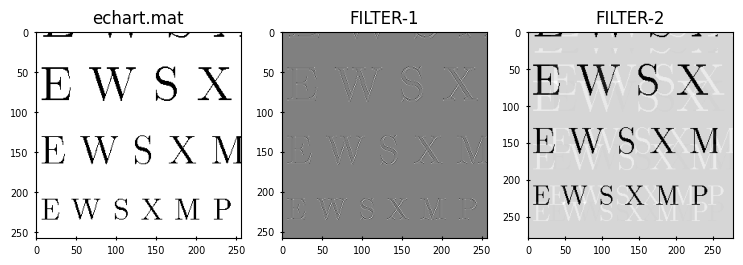

In [9]:
%config InlineBackend.figure_formats = ['png']
# create impulse response for FILTER-1
q = 0.9
r = 0.9
M = 22
h1_n = np.array([1, -q])

# create impulse response for FILTER-2
n = np.arange(M)
h2_n = r**n

# load image file
echart = loadmat("data/echart.mat")["echart"]

# normalize so image max is 1
echart = 1 - (echart / 255)

# apply FILTER-1 to image in both horizontal and vertical directions
ech90 = filter_2d(echart, h1_n)
# undo the effects of FILTER 1 by applying the deconvolutional filter to the result
ech90_decv = filter_2d(ech90, h2_n)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 5))
ax1.imshow(echart, cmap="binary")
ax1.set_title("echart.mat")
ax1.grid(False)

ax1.imshow(echart, cmap="binary")
ax1.set_title("echart.mat")
ax1.grid(False)

ax2.imshow(ech90, cmap="binary")
ax2.set_title("FILTER-1")
ax2.grid(False)

ax3.imshow(ech90_decv, cmap="binary")
ax3.set_title("FILTER-2")
ax3.grid(False)

plt.show()

Ghosts are seen in the output image due to an imperfect deconvolution. The convolution of the first filter was done in the horizontal and vertical directions. The restoration filter removed nearly all of the effect of the first filter, but there is a small negative "echo" that is seen that was not removed with the deconvolution filter. This "echo" that is left is 0.1 times the size of the original value and will be M = 22 samples delayed over.

In [10]:
# subtract the result of FILTER 2 from the original image. Images must be the same size for the comparison to work,
# so drop the last M-1 pixels from the deconvolved image
ech90_decnewshp = ech90_decv[0:-22, 0:-22]
im_error = np.abs(ech90_decnewshp - echart)
max_error = np.max(im_error)
print("For a scale of 0-255:")
print(f"Maximum Error found is {256*max_error}")

For a scale of 0-255:
Maximum Error found is 50.42027019180097


The worst case error for values up to 0-255 is 50.42

# 3.2.3 A Second Restoration Experiment
-----------

# (a) 

Now try to deconvolve ech90 with several different FIR filters for FILTER-2. You should set r = 0.9 and try several values for M such as 11, 22 and 33. Pick the best result and explain why it is the best. Describe the visual appearance of the output, and explain its features by invoking your mathematical understanding of the cascade filtering process. HINT: determine the impulse response of the cascaded system and relate it to the visual appearance of the output image.

As seen below, the best result is the version with M = 33. This result is the best because the filter order has been increased to 33. This increased filter order allows the value of r to increase and thus the effect of the impulse response from the first difference filter is lessened. The small amount of distortion ("echo") that remains is moved further away from the desired signal as well. As seen in the overall impulse response, there is a small negative distortion/echo that remains on the signal. As the value of M increases, this distortion decreases and moves away from the original signal.

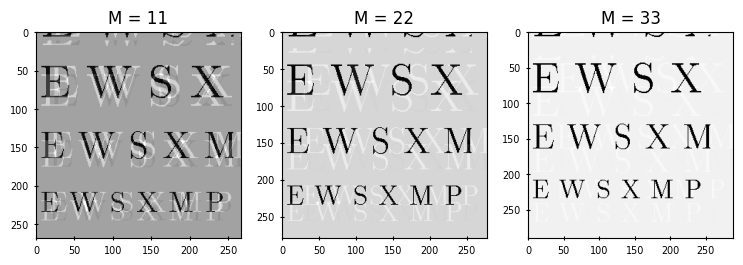

In [11]:
# create impulse responses for filters with M= 11, 22, and 33
M0 = 11
M1 = 22
M2 = 33

h2_n0 = r ** np.arange(M0)
h2_n1 = r ** np.arange(M1)
h2_n2 = r ** np.arange(M2)

# apply each filter to the FILTER-1 result
ech90_decv0 = filter_2d(ech90, h2_n0)
ech90_decv1 = filter_2d(ech90, h2_n1)
ech90_decv2 = filter_2d(ech90, h2_n2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 6))
ax1.imshow(ech90_decv0, cmap="binary")
ax1.set_title("M = 11")

ax2.imshow(ech90_decv1, cmap="binary")
ax2.set_title("M = 22")

ax3.imshow(ech90_decv2, cmap="binary")
ax3.set_title("M = 33")

for ax in (ax1, ax2, ax3):
    ax.grid(False)

# (b) 

Furthermore, when you consider that a gray-scale display has 256 levels, how large is the worst-case error (from the previous part) in terms of number of gray levels? Do this calculation for each of the three filters in part (a). Think about the following question: “Can your eyes perceive a gray scale change of one level, i.e., one part in 256?”


In [12]:
# subtract each filter result from the original image
ech90_decnewshp0 = ech90_decv0[0:-M0, 0:-M0]
ech90_decnewshp1 = ech90_decv1[0:-M1, 0:-M1]
ech90_decnewshp2 = ech90_decv2[0:-M2, 0:-M2]

im_error1 = np.abs(ech90_decnewshp0 - echart)
im_error2 = np.abs(ech90_decnewshp1 - echart)
im_error3 = np.abs(ech90_decnewshp2 - echart)

max_error1 = np.max(im_error1)
max_error2 = np.max(im_error2)
max_error3 = np.max(im_error3)

print("For a scale of 256:")
print(f"Maximum Error found is {256*max_error1}")
print(f"Maximum Error found is {256*max_error2}")
print(f"Maximum Error found is {256*max_error3}")

For a scale of 256:
Maximum Error found is 160.67102519808012
Maximum Error found is 50.42027019180097
Maximum Error found is 15.822415043907938


The maximum error for M=11 is 160.67, M=22 is 50.42 and M=33 is 15.82.
It would be difficult for our eyes to perceive this change. With an error value of ~16, the distortion is nearly imperceivable. If this error value were to approach one part in 256, the distortion would not be visible to the human eye. 

# Lab P-10: Edge Detection and Bar Code Decoding
--------

# 3.1

Implement the first difference FIR filter,
$$
y[n] = x[n] - x[n-1]
$$

On the following signal,
```
xn = 255*(rem(1:159,30)>19)
```

The signal is implemented in Python with,
```python
xn = 255 * ((x % 30) > 19)
```

The impulse response $h[n]$ for this FIR filter is,
$$
h[n] = [1, -1]
$$

## (a)
Plot both the input and output waveforms $x[n]$ and $y[n]$. 

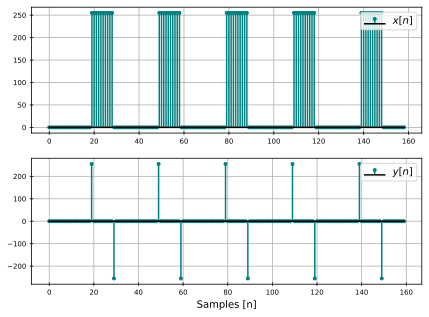

In [13]:
%config InlineBackend.figure_formats = ['svg']

# create xn signal
n = np.arange(1, 160)
xn = 255 * ((n % 30) > 19)

# apply the FIR filter to the input signal using convolution
hn = np.array([1, -1])
yn = np.convolve(xn, hn)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
stem_plot(ax1, np.arange(len(xn)), xn, markersize=3)
stem_plot(ax2, np.arange(len(yn)), yn, markersize=3)
ax1.legend(["$x[n]$"], loc="upper right")
ax2.legend(["$y[n]$"], loc="upper right")
ax2.set_xlabel("Samples [n]");

## (b)
The output $y[n]$ is simply the difference of the current sample $n$ with the previous sample value at $n-1$. When the input $x[n]$ is constant between the current and last sample, the output is zero, but is non-zero when an edge occurs. The value of $y[n]$ at the edges is the difference in the two sample values, so it has a value of 255 when the input transitions from 0 to 255 (positive edge), and -255 when the input transitions from 255 back to 0 (negative edge).

## (c)

The length of $y[n]$ is related to the length of the input at the filter impulse response using the convolution property,

$$
\mathrm{len}(y[n]) = \mathrm{len}(x[n])+ \mathrm{len}({h[n]}) -1 
$$

In [14]:
print("XN:{} HN: {}, YN: {}".format(len(xn), len(hn), len(yn)))

XN:159 HN: 2, YN: 160


## (d)

Determine an appropriate value of the threshold $\tau$ to get the edges of the input. 

$$ d[n] = 
\begin{cases}
\mathrm{Edge \ True} & \mathrm{if \ } |y[n]|  > \tau \\
\mathrm{Edge \ False} & \mathrm{if \ } |y[n]| < \tau
\end{cases}
$$

For this signal, an appropriate threshold is half of the maximum value of $x[n]$ or 255.
$$ \tau = \mathrm{max}(x[n]) /2 $$

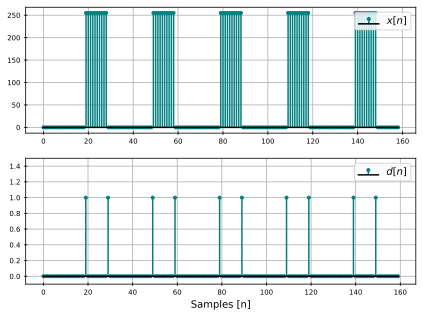

In [15]:
# normalized edge detector. A transition is considered an edge if the differnce is half the maximum value of xn
tau = 255 / 2
edges_n = np.where(np.abs(yn) > tau, 1, 0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
stem_plot(ax1, np.arange(len(xn)), xn, markersize=3)
stem_plot(ax2, np.arange(len(edges_n)), edges_n, markersize=3)
ax2.set_ylim([-0.1, 1.5])
ax1.legend(["$x[n]$"], loc="upper right")
ax2.legend(["$d[n]$"], loc="upper right")
ax2.set_xlabel("Samples [n]");

## (e)

Produce a shorter signal that contains the edge locations. Determine the length of this signal and plot it.

The length of this signal is 10 samples since there are 10 edges in the input signal.

Length of edge signal: 10


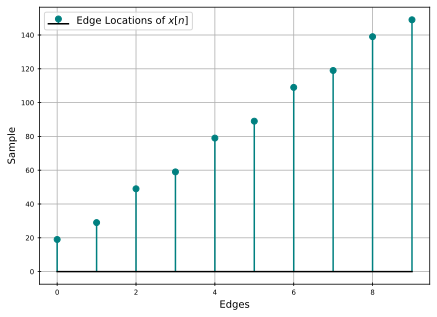

In [16]:
# nonzero returns the indices of the non-zero values, and the non-zero values. We only care
# about the indices, which we name edges_samples.
edges_samples = np.nonzero(edges_n)[0]

fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
stem_plot(ax1, np.arange(len(edges_samples)), edges_samples)
ax1.grid(True)
ax1.set_ylabel("Sample")
ax1.set_xlabel("Edges")
ax1.legend(["Edge Locations of $x[n]$"], loc="upper left")
print(f"Length of edge signal: {len(edges_samples)}")

# 3.2
----
Develop the signal processing needed to decode a typical bar code from a scanned image.

## (a)
Read the image HP110v3.png and extract one row in the middle to define a 1-D signal x[n] for processing.

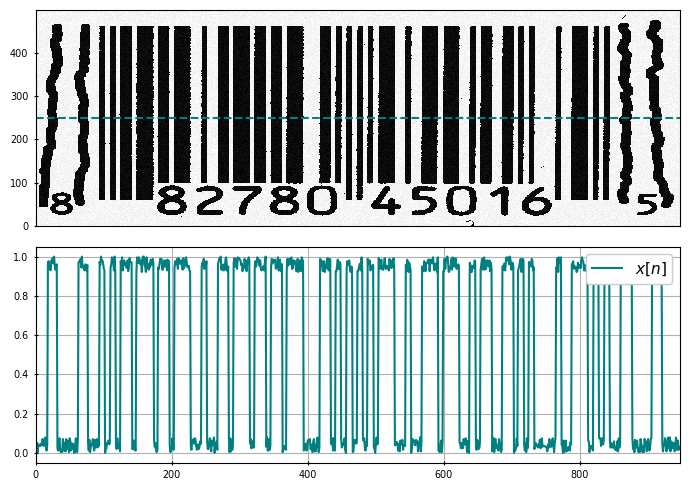

In [17]:
%config InlineBackend.figure_formats = ['png']
imagepath = "data/HP110v3.png"
im = 1 - plt.imread(imagepath)

# x and y vectors along image [pixels]
m, n = np.arange(len(im)), np.arange(len(im[0]))

# extract one row to read
read_row = int(len(m) / 2) - 1
xn = im[read_row]

fig, (im1, ax1) = plt.subplots(2, 1, figsize=(7, 5))
# plot the image, n is the columns which we want on the x-axis
n_mesh, m_mesh = np.meshgrid(n, np.flip(m))
im1.pcolormesh(n_mesh, m_mesh, im, cmap="binary")

# plot the location of the single row used for processing
im1.axhline(y=read_row, linestyle="dashed")
ax1.plot(np.arange(len(xn)), xn)
ax1.legend(["$x[n]$"], fontsize=11, loc="upper right", framealpha=1)

im1.grid(False)
ax2.set_xlabel("Pixel [n]")
im1.set_xticks([])
for ax in (im1, ax1):
    ax.set_xlim([n[0], n[-1]])

plt.tight_layout()

# (b)
Filter the signal $x[n]$ with a first difference FIR filter. 
$$
y[n] = x[n] - x[n-1]
$$

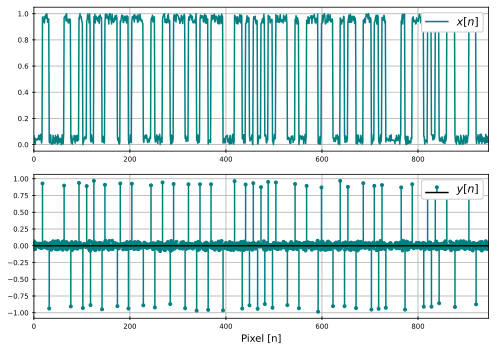

In [18]:
%config InlineBackend.figure_formats = ['svg']

# first difference filter of row signal
hn = np.array([1, -1])
yn = np.convolve(xn, hn)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
ax1.plot(np.arange(len(xn)), xn)
stem_plot(ax2, np.arange(len(yn)), yn, markersize=3)

ax1.legend(["$x[n]$"], fontsize=11, loc="upper right", framealpha=1)
ax2.legend(["$y[n]$"], fontsize=11, loc="upper right", framealpha=1)

ax2.set_xlabel("Pixel [n]")
for ax in (im1, ax1, ax2):
    ax.set_xlim([n[0], n[-1]])

plt.tight_layout()

# (c)
Create a sparse detected signal $d[n]$ by comparing the magnitude $|y[n]|$ to a threshold.

Use $\tau=0.5$ as the edge threshold.

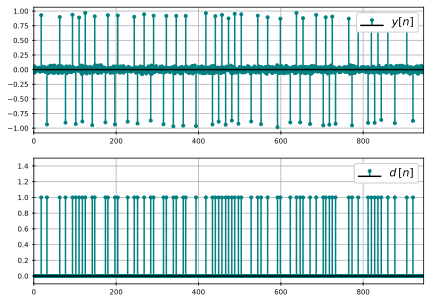

In [19]:
# apply edge threshold, difference must be 0.5 to be considered a valid edge
dn = np.where(np.abs(yn) > 0.5, 1, 0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))

stem_plot(ax1, np.arange(len(yn)), yn, markersize=3)
stem_plot(ax2, np.arange(len(dn)), dn, markersize=3)
ax2.set_ylim([-0.1, 1.5])

ax1.legend(["$y[n]$"], fontsize=11, loc="upper right", framealpha=1)
ax2.legend(["$d \, [n]$"], fontsize=11, loc="upper right", framealpha=1)

for ax in (im1, ax1, ax2):
    ax.set_xlim([n[0], n[-1]])

Then convert the sparse signal $d[n]$ into a location signal $\ell[n]$ by using the find function to extract locations.

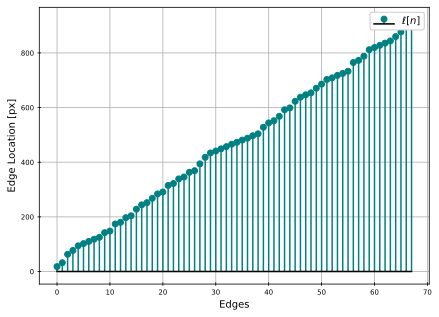

In [20]:
# pixel locations where edges occur
edge_loc = np.nonzero(dn)[0]

fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
stem_plot(ax1, np.arange(len(edge_loc)), edge_loc)
ax1.set_ylabel("Edge Location [px]")
ax1.set_xlabel("Edges")
ax1.legend(["$\ell[n]$"], loc="upper right", framealpha=1)

## (d)
Apply a first difference filter to $\ell[n]$, call this signal $\Delta[n]$, which should be the width of each bar.

All of the bar widths of $\Delta[n]$ are grouped around four distinct values (8, 16, 24, 32px), which indicates there are 4 unique bar widths. 

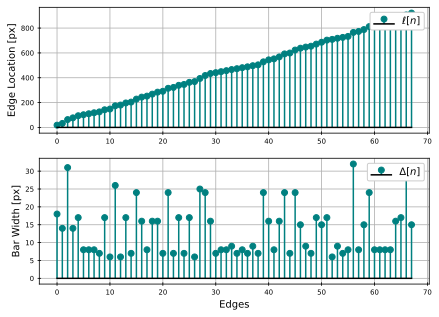

In [21]:
# difference filter on the location signal
delta_n = np.convolve(edge_loc, hn, mode="same")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
stem_plot(ax1, np.arange(len(edge_loc)), edge_loc)
stem_plot(ax2, np.arange(len(delta_n)), delta_n)

ax1.set_ylabel("Edge Location [px]")
ax2.set_ylabel("Bar Width [px]")
ax2.set_xlabel("Edges")

ax1.legend(["$\ell[n]$"], loc="upper right", framealpha=1)
ax2.legend(["$\Delta[n]$"], loc="upper right", framealpha=1);

## (e)
Prove that the total width of a valid 12-digit bar code is equal to 95 $\theta_1$, where $\theta_1$ is the minimum bar width in pixels. Write a logical
argument to justify this total width.

Each encoded digit contains 7 units:   
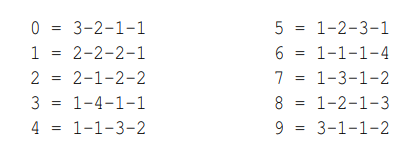

So the 12-digits take up a total width of 84 units, or 84 $\theta_1$. The 12 digits are delimited by three bars of width $\theta_1$ on either end, as well as separated between the 6th and 7th digit by 5 bars. The full length of the bar code is,

$$ 84 \theta_1 + 6\theta_1 + 5 \theta_1  = 95 \theta_1 $$

## (f)
Derive a simple method to estimate $\theta_1$ from the signal $\Delta[n]$.

For a valid barcode, the bar widths are multiples of the thinnest bar. This means that we can draw a line halfway between the bar widths with the smallest widths in $\Delta[n]$, and the next largest bars. Any bar below this line will be considered $\theta_1$, and any above are considered $2\theta_1$. To estimate $\theta_1$ for a noisy image, we average all the bar widths below this imaginary line, which we draw at 1.5x the minimum bar width found in the image.

This method gives $\theta_1 = 7.5$ for this image.

In [22]:
# determine minimum bar width in pixels
# take all widths smaller than 1.8x the minimum and take the average
min_width_group = delta_n[delta_n <= (np.min(delta_n) * 1.5)]
delta_1 = np.average(min_width_group)

print(f"delta_1 = {delta_1}")

delta_1 = 7.529411764705882


## (g)
Using the estimate for $\delta_1$, convert $\Delta[n]$ into relative sizes by dividing by $\theta_1$ and rounding. 

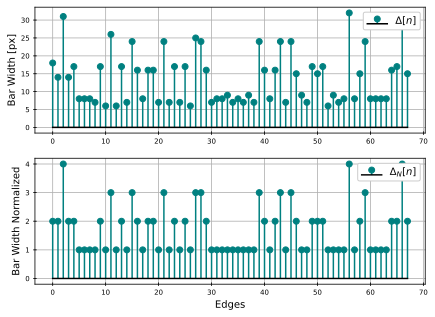

In [23]:
# normalize the bar widths by delta_1, and clip between 1 and 4.
delta_norm_n = np.clip(np.round(delta_n / delta_1), 1, 4)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
stem_plot(ax1, np.arange(len(delta_n)), delta_n)
stem_plot(ax2, np.arange(len(delta_n)), delta_norm_n)

ax1.set_ylabel("Bar Width [px]")
ax2.set_ylabel("Bar Width Normalized")
ax2.set_xlabel("Edges")
ax2.set_yticks([0, 1, 2, 3, 4])

ax1.legend(["$\Delta[n]$"], loc="upper right", framealpha=1)
ax2.legend(["$\Delta_N[n]$"], loc="upper right", framealpha=1)

## (h)
Decode the normalized $\Delta[n]$ signal into digits.

In [24]:
# find the first sequence of 3 ones, this marks the beginning and end of a valid code
delimiter_match = np.convolve(delta_norm_n, [1, 1, 1])
delimiter_loc = np.argwhere(delimiter_match == 3).flatten()
start_loc, stop_loc = delimiter_loc[0] - 2, delimiter_loc[-1]

# clip start location to 0
start_loc = 0 if start_loc < 0 else start_loc
# clip the sequence at the delimters
bar_w = delta_norm_n[start_loc : stop_loc + 1]

# a valid bar code should have 59 widths excluding the delimiters
assert len(bar_w) == 59

print(upc_decode(bar_w))

[8, 8, 2, 7, 8, 0, 4, 5, 0, 1, 6, 5]


# (i)

Check the result using the included code in the image.

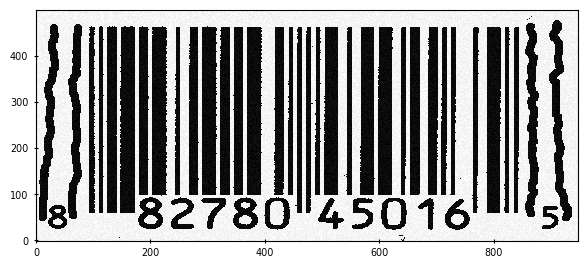

In [25]:
%config InlineBackend.figure_formats = ['png']

fig, (im1) = plt.subplots(1, 1, figsize=(7, 3))
# plot the image, n is the columns which we want on the x-axis
n_mesh, m_mesh = np.meshgrid(n, np.flip(m))
im1.pcolormesh(n_mesh, m_mesh, im, cmap="binary")
im1.grid(False)

# (j)

Process the image `Offv3.png`.

Because this image is slanted and the thinnest bar is only 2-3 pixels wide, it is helpful to average the $\Delta_n$ signals of several rows in the middle of the image.

[0, 4, 6, 5, 0, 0, 7, 0, 3, 1, 9, 5]

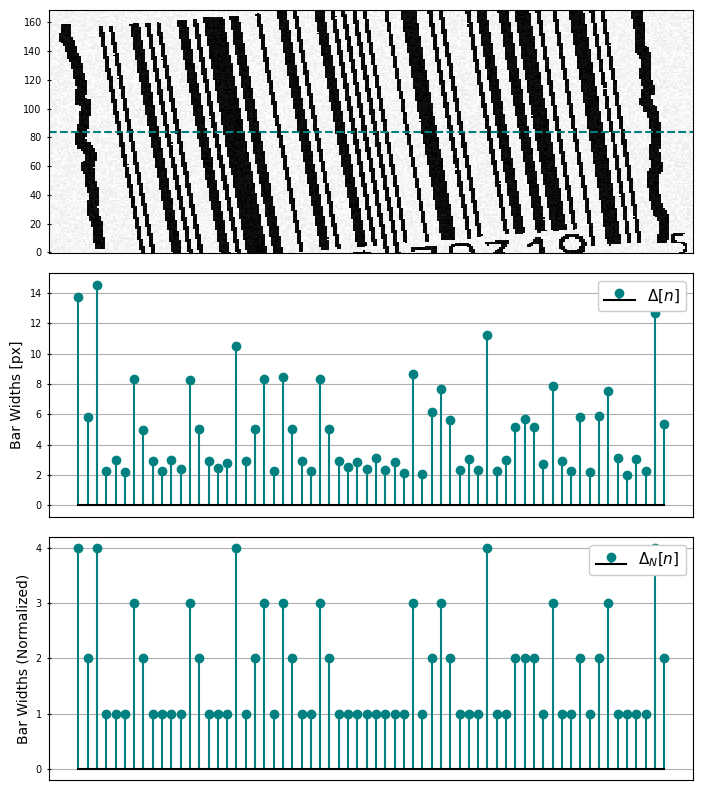

In [26]:
imagepath = "data/OFFv3.png"
decode_image(imagepath)

In [27]:
from IPython.display import display, HTML
from ipylab import JupyterFrontEnd
import subprocess

app = JupyterFrontEnd()

display(
    HTML(
        "<style>"
        ".jp-Cell { overflow-x: visible; overflow: visible; "
        "width: 95%; max-width: 960px; "
        "margin-left: auto; margin-right: auto; }"
        "img {"
        "width: 90%;"
        "height: 100%;}"
        ".jp-Cell-inputWrapper { width: 95%; overflow-x: visible; overflow: visible;}"
        "</style>"
    )
)

app.commands.execute("docmanager:save")
subprocess.run("jupyter nbconvert --to html report.ipynb", shell=True)
app.commands.execute("docmanager:save");